# import&constants

In [ ]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K 

import metrics
import utils
import keras.utils

In [ ]:
import skimage.transform

In [ ]:
import os
import tensorflow as tf
import random

In [ ]:
# !pip show tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load image

In [ ]:
def swapHelper(img):
  img = np.swapaxes(img, 0, 1)
  img = np.swapaxes(img, 1, 2)
  img = np.swapaxes(img, 2, 3)
  return img

In [ ]:
def load_case(id, isTrain):
    # load the image and label file, get the image content and return a numpy array for each
    if isTrain is True:
      image = np.load(f'drive/MyDrive/data_pub/train/{id:03}_imgs.npy')
      label = np.load(f'drive/MyDrive/data_pub/train/{id:03}_seg.npy')
    else:
      image = np.load(f'drive/MyDrive/data_pub/validation/{id:03}_imgs.npy')
      label = np.load(f'drive/MyDrive/data_pub/validation/{id:03}_seg.npy')
    image = swapHelper(image)
    image = skimage.transform.resize(image, (128,128,128,4), preserve_range = True)
    label = skimage.transform.resize(label, (128,128,128), preserve_range = True).astype(int)
    return image, label

In [ ]:
def get_sub_volume(image, label, 
                   orig_x = 128, orig_y = 128, orig_z = 128, 
                   output_x = 96, output_y = 96, output_z = 16,
                   num_classes = 4, max_tries = 1000, 
                   background_threshold=0.95):
    """
    Extract random sub-volume from original images.

    Args:
        image (np.array): original image, 
            of shape (orig_x, orig_y, orig_z, num_channels)
        label (np.array): original label. 
            labels coded using discrete values rather than
            a separate dimension, 
            so this is of shape (orig_x, orig_y, orig_z)
        orig_x (int): x_dim of input image
        orig_y (int): y_dim of input image
        orig_z (int): z_dim of input image
        output_x (int): desired x_dim of output
        output_y (int): desired y_dim of output
        output_z (int): desired z_dim of output
        num_classes (int): number of class labels
        max_tries (int): maximum trials to do when sampling
        background_threshold (float): limit on the fraction 
            of the sample which can be the background

    returns:
        X (np.array): sample of original image of dimension 
            (num_channels, output_x, output_y, output_z)
        y (np.array): labels which correspond to X, of dimension 
            (num_classes, output_x, output_y, output_z)
    """
    # Initialize features and labels with `None`
    X = None
    y = None

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    tries = 0
    
    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        # hint: make sure to leave enough room for the output dimensions!
        start_x = np.random.randint(0,orig_x-output_x+1)
        start_y = np.random.randint(0,orig_x-output_x+1)
        start_z = np.random.randint(0,orig_x-output_x+1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]
        
        # One-hot encode the categories.
        # This adds a 4th dimension, 'num_classes'
        # (output_x, output_y, output_z, num_classes)
        y = keras.utils.to_categorical(y, num_classes)

        # compute the background ratio
        bgrd_ratio = y[:,:,:,0].sum()/(output_x * output_y * output_z)


        # increment tries counter
        tries += 1

        # if background ratio is below the desired threshold,
        # use that sub-volume.
        # otherwise continue the loop and try another random sub-volume
        if bgrd_ratio < background_threshold:

            # make copy of the sub-volume
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            
            # change dimension of X
            # from (x_dim, y_dim, z_dim, num_channels)
            # to (num_channels, x_dim, y_dim, z_dim)
            X = np.moveaxis(X,-1,0)

            # change dimension of y
            # from (x_dim, y_dim, z_dim, num_classes)
            # to (num_classes, x_dim, y_dim, z_dim)
            y = np.moveaxis(y,-1,0)

            ### END CODE HERE ###
            
            # take a subset of y that excludes the background class
            # in the 'num_classes' dimension
            y = y[1:, :, :, :]
    
            return X, y

    # if we've tried max_tries number of samples
    # Give up in order to avoid looping forever.
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

In [ ]:
def load_case_categorical(id, isTrain):
    # load the image and label file, get the image content and return a numpy array for each
    if isTrain is True:
      image = np.load(f'drive/MyDrive/data_pub/train/{id:03}_imgs.npy')
      label = np.load(f'drive/MyDrive/data_pub/train/{id:03}_seg.npy')
    else:
      image = np.load(f'drive/MyDrive/data_pub/validation/{id:03}_imgs.npy')
      label = np.load(f'drive/MyDrive/data_pub/validation/{id:03}_seg.npy')
    image = swapHelper(image)
    image = skimage.transform.resize(image, (128,128,128,4), preserve_range = True)
    label = keras.utils.to_categorical(label, 4)
    label = skimage.transform.resize(label, (128,128,128,4), preserve_range = True).astype(int)
    return image, label

# Load image test

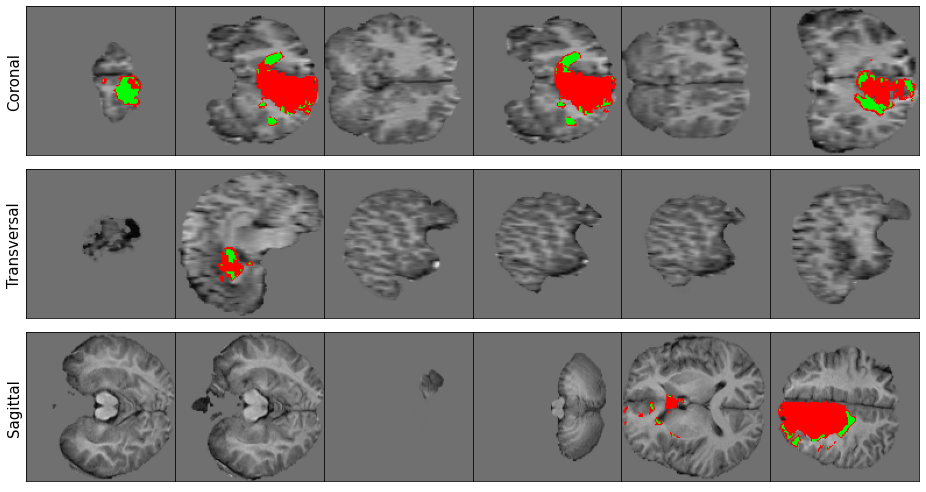

In [ ]:
img, lbl = load_case(2, True)
image = utils.get_labeled_image(img, lbl)

utils.plot_image_grid(image)

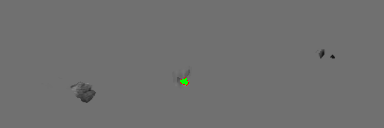

In [ ]:
utils.visualize_data_gif(image)

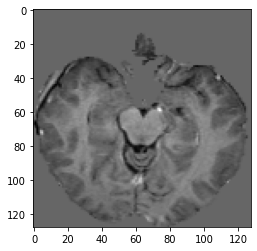

In [ ]:
plt.imshow(img[50,:,:,1], cmap='gray')

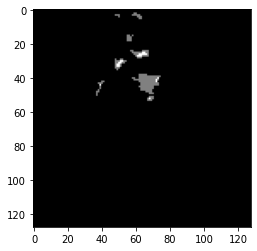

In [ ]:
plt.imshow(lbl[70], cmap='gray')

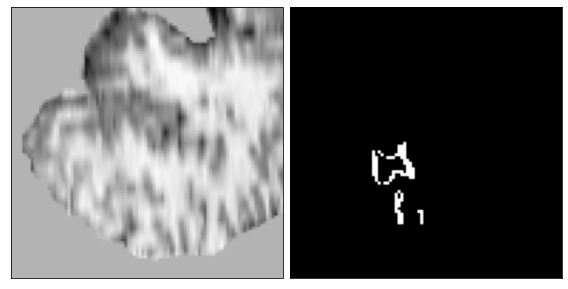

In [ ]:
X, y = get_sub_volume(img, lbl)
utils.visualize_patch(X[0,:,:,:], y[0])

# Normalize

In [ ]:
# HOUNSFIELD_MIN = -6
# HOUNSFIELD_MAX = 15
# HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

In [ ]:
# def normalizeImageIntensityRange(img):
#     img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
#     img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
#     return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

In [ ]:
def standardize(image):
    """
    Standardize mean and standard deviation 
        of each channel and z_dimension.

    Args:
        image (np.array): input image, 
            shape (num_channels, dim_x, dim_y, dim_z)

    Returns:
        standardized_image (np.array): standardized version of input image
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # initialize to array of zeros, with same shape as the image
    # initialize to array of zeros, with same shape as the image
    standardized_image = np.zeros(image.shape)

    # iterate over channels
    for c in range(image.shape[0]):
        # iterate over the `z` dimension
        for z in range(image.shape[3]):
            # get a slice of the image 
            # at channel c and z-th dimension `z`
            image_slice = image[c,:,:,z]

            # subtract the mean from image_slice
            centered = image_slice - image_slice.mean()
            
            # divide by the standard deviation (only if it is different from zero)
            if image_slice.std()!=0:
                centered_scaled = centered/image_slice.std()

            # update  the slice of standardized image
            # with the scaled centered and scaled image
            standardized_image[c, :, :, z] =centered_scaled
    ### END CODE HERE ###

    return standardized_image

In [ ]:
# X_norm = standardize(X)

In [ ]:
# utils.visualize_patch(X_norm[0, :, :, :], y[0])

# Dice loss

In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=1e-6):
    """
    Compute mean dice coefficient over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant add to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """
    
    dice_numerator =2* K.sum(y_pred * y_true,axis=axis) + epsilon
    dice_denominator = (K.sum(y_pred**2,axis=axis) + K.sum(y_true**2,axis=axis)) + epsilon
    dice_coefficient = K.mean(dice_numerator / dice_denominator)
    
    return dice_coefficient

In [ ]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator =2* K.sum(y_pred * y_true,axis=axis) + epsilon
    dice_denominator = (K.sum(y_pred**2,axis=axis) + K.sum(y_true**2,axis=axis)) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)
    return dice_loss

In [ ]:
def weighted_dice_coefficient(y_true, y_pred, axis=(-3, -2, -1), smooth=0.00001):
    """
    Weighted dice coefficient. Default axis assumes a "channels first" data structure
    :param smooth:
    :param y_true:
    :param y_pred:
    :param axis:
    :return:
    """
    return K.mean(2. * (K.sum(y_true * y_pred,
                              axis=axis) + smooth/2)/(K.sum(y_true,
                                                            axis=axis) + K.sum(y_pred,
                                                                               axis=axis) + smooth))


def weighted_dice_coefficient_loss(y_true, y_pred):
    return 1-weighted_dice_coefficient(y_true, y_pred)

def label_wise_dice_coefficient(y_true, y_pred, label_index):
    return dice_coefficient(y_true[:, label_index], y_pred[:, label_index])

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coefficient_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

# Data Augmentation funtions

In [ ]:
def flip_image(image, axis):
    try:
        new_data = np.copy(image)
        for axis_index in axis:
            new_data = np.flip(new_data, axis=axis_index)
    except TypeError:
        new_data = np.flip(image, axis=axis)
    return new_data

# Generator

In [ ]:
def generatorTrain(batch_size):
  while True:
    ids = list(range(1,205,1))
    X = np.zeros((batch_size, 4, 128, 128, 128))
    y = np.zeros((batch_size, 3, 128, 128, 128))
    # cnt = 1
    while len(ids) > 0:
      for i in range(batch_size):
        cnt = random.choice(ids)
        img = np.load(f'drive/MyDrive/data_pub/train/{cnt:03}_imgs.npy')
        seg = np.load(f'drive/MyDrive/data_pub/train/{cnt:03}_seg.npy')
        img = skimage.transform.resize(img, (4, 128, 128, 128), preserve_range=True)
        img = standardize(img)
        # img = np.moveaxis(img, 0,-1)
        seg = skimage.transform.resize(seg, (128, 128, 128), preserve_range=True).astype(int)
        seg = keras.utils.to_categorical(seg,4)
        seg = np.moveaxis(seg,-1,0)
        # pop from list
        ids.remove(cnt)
        # augment data by flipping
        # aug = random.choice([True, False])
        # if aug:
        #   axis = random.randint(1,3)
        #   img = np.flip(img, axis)
        #   seg = np.flip(seg, axis)
        X[i] = img
        y[i] = seg[1:]
      yield X, y

In [ ]:
def generatorVal(batch_size):
  while True:
    ids = list(range(1,69,1))
    X = np.zeros((batch_size, 4, 128, 128, 128))
    y = np.zeros((batch_size, 3, 128, 128, 128))
    # cnt = 1
    while len(ids) > 0:
      for i in range(batch_size):
        cnt = random.choice(ids)
        # print(f'loading case {cnt}')
        img = np.load(f'drive/MyDrive/data_pub/validation/{cnt:03}_imgs.npy')
        seg = np.load(f'drive/MyDrive/data_pub/validation/{cnt:03}_seg.npy')
        img = skimage.transform.resize(img, (4, 128, 128, 128), preserve_range=True)
        img = standardize(img)
        
        seg = skimage.transform.resize(seg, (128, 128, 128), preserve_range=True).astype(int)
        seg = keras.utils.to_categorical(seg,4)
        seg = np.moveaxis(seg,-1,0)
        # pop from list
        ids.remove(cnt)
        # augment data by flipping
        # aug = random.choice([True, False])
        # if aug:
        #   axis = random.randint(1,3)
        #   img = np.flip(img, axis)
        #   seg = np.flip(seg, axis)
        X[i] = img
        y[i] = seg[1:]
      yield X, y

In [ ]:
test_gen = generatorVal(1)
for i in range(70):
  testx, testy = next(test_gen)
  print(np.max(testx), np.min(testx), np.max(testy), np.min(testy))
print('success')
# for i in range(3):
#   plt.imshow(testy[0,i, :, :, 30], cmap='gray')
#   plt.show()

# Compile model

In [ ]:
model = utils.unet_model_3d(loss_function=dice_coefficient_loss, metrics=[dice_coefficient], input_shape=(4,128,128,128),
                            include_label_wise_dice_coefficients=True,initial_learning_rate=1e-05)

In [ ]:
model.summary()

In [ ]:
train_generator = generatorTrain(2)
val_generator = generatorVal(2)

In [ ]:
if os.path.isdir("drive/MyDrive/model3dunetShuffle_utils_changed") is False:
  os.mkdir("drive/MyDrive/model3dunetShuffle_utils_changed")
checkpoint_path = "drive/MyDrive/model3dunetShuffle_utils_changed/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
model.load_weights('drive/MyDrive/model3dunet_test/cp-0005.ckpt')

In [ ]:
model.fit_generator(generator=train_generator,
        steps_per_epoch=204,
        validation_data=val_generator,
        validation_steps=68,
        callbacks=[cp_callback],
        epochs=20)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
204/204 [==============================] - 923s 4s/step - loss: 0.9320 - dice_coefficient: 0.0680 - label_0_dice_coef: 0.0518 - label_1_dice_coef: 0.1209 - label_2_dice_coef: 0.0266 - val_loss: 0.8477 - val_dice_coefficient: 0.1523 - val_label_0_dice_coef: 0.1072 - val_label_1_dice_coef: 0.2829 - val_label_2_dice_coef: 0.0549

Epoch 00001: saving model to drive/MyDrive/model3dunetShuffle_utils_changed/cp-0001.ckpt
Epoch 2/20
204/204 [==============================] - 902s 4s/step - loss: 0.8277 - dice_coefficient: 0.1723 - label_0_dice_coef: 0.1240 - label_1_dice_coef: 0.2947 - label_2_dice_coef: 0.0780 - val_loss: 0.8197 - val_dice_coefficient: 0.1803 - val_label_0_dice_coef: 0.1344 - val_label_1_dice_coef: 0.3074 - val_label_2_dice_coef: 0.0668

Epoch 00002: saving model to drive/MyDrive/model3dunetShuffle_utils_changed/cp-0002.ckpt
Epoch 3/20
204/204 [==============================] - 901s 4s/step - loss: 0.8095 - dice_coefficient: 0.1905 - label_0_dice_coef: 0.1570 - lab

KeyboardInterrupt: ignored

In [ ]:
model.load_weights('drive/MyDrive/model3dunetShuffle_utils_changed/cp-0010.ckpt')

In [ ]:
train_generator = generatorTrain(1)
val_generator = generatorVal(1)

In [ ]:
if os.path.isdir("drive/MyDrive/3dunet_model_latest") is False:
  os.mkdir("drive/MyDrive/3dunet_model_latest")
checkpoint_path = "drive/MyDrive/3dunet_model_latest/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
model.load_weights('drive/MyDrive/3dunet_model/cp-0058.ckpt')

In [18]:
model.fit_generator(generator=train_generator,
        steps_per_epoch=204,
        validation_data=val_generator,
        validation_steps=68,
        callbacks=[cp_callback],
        epochs=200)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
204/204 [==============================] - 952s 5s/step - loss: 0.2467 - dice_coefficient: 0.7533 - label_0_dice_coef: 0.6067 - label_1_dice_coef: 0.7818 - label_2_dice_coef: 0.5666 - val_loss: 0.3818 - val_dice_coefficient: 0.6182 - val_label_0_dice_coef: 0.4538 - val_label_1_dice_coef: 0.6626 - val_label_2_dice_coef: 0.4720

Epoch 00001: saving model to drive/MyDrive/3dunet_model_latest/cp-0001.ckpt
Epoch 2/200
204/204 [==============================] - 956s 5s/step - loss: 0.2464 - dice_coefficient: 0.7536 - label_0_dice_coef: 0.6087 - label_1_dice_coef: 0.7812 - label_2_dice_coef: 0.5667 - val_loss: 0.3733 - val_dice_coefficient: 0.6267 - val_label_0_dice_coef: 0.4687 - val_label_1_dice_coef: 0.6657 - val_label_2_dice_coef: 0.4884

Epoch 00002: saving model to drive/MyDrive/3dunet_model_latest/cp-0002.ckpt
Epoch 3/200
204/204 [==============================] - 971s 5s/step - loss: 0.2416 - dice_coefficient: 0.7584 - label_0_dice_coef: 0.6145 - label_1_dice_coef: 0.7838 

KeyboardInterrupt: ignored

In [ ]:
# model.save('drive/MyDrive/model3dunet/3dunetModel1.h5')

# Test prediction

## Test Generator

In [ ]:
dimensions = []

In [ ]:
def generatorTest(batch_size=1):
  dimensions = []
  X = np.zeros((batch_size, 4, 128, 128, 128))
  cnt = 1
  while cnt < 69:
    for i in range(batch_size):
      img = np.load(f'drive/MyDrive/test_pub/{cnt:03}_imgs.npy')
      dimensions.append(img.shape)
      img = skimage.transform.resize(img, (4, 128, 128, 128), preserve_range=True)
      img = standardize(img)
      cnt += 1
      X[i] = img
    yield X

## Predict

In [ ]:
test = np.load('drive/MyDrive/data_pub/validation/001_imgs.npy')
test = skimage.transform.resize(test, (4,128,128,128), preserve_range=True)
test = standardize(test)

In [ ]:
# val_loss, val_dice = model.evaluate_generator(val_generator)

# print(f"validation soft dice loss: {val_loss:.4f}")
# print(f"validation dice coefficient: {val_dice:.4f}")

In [ ]:
results = model.predict(np.array([test]))

In [ ]:
results.shape

(1, 3, 128, 128, 128)

In [ ]:
# set threshold.
def combine(result, threshold=0.5):
  p = np.zeros((4,128,128,128))

  for i in range(128):
    for j in range(128):
      for k in range(128):
        v = result[:,i,j,k]
        if np.max(v) <= 0.5:
          p[0,i,j,k] = 1
        else:
          label = np.argmax(v) + 1
          p[label, i,j,k] = 1
  return p


In [ ]:
p = combine(results[0])

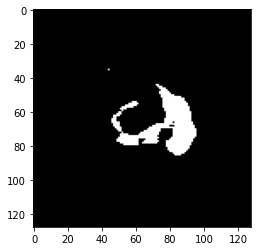

In [ ]:
plt.imshow(p[2, :, :, 30], cmap='gray')

In [ ]:
pred = np.argmax(p, axis=0)
pred.shape, np.max(pred), np.min(pred)

((128, 128, 128), 2, 0)

In [ ]:
pred[:,:,30]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

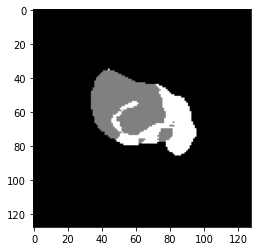

In [ ]:
plt.imshow(pred[:, :, 30], cmap='gray')

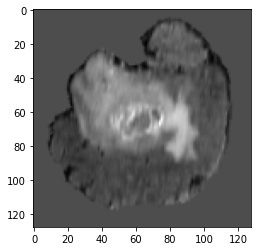

In [ ]:
plt.imshow(test[3,:,:,30], cmap='gray')

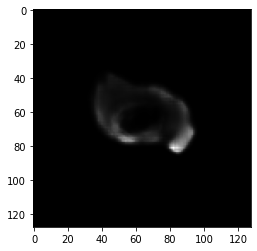

In [ ]:
plt.imshow(results[0,2, :, :, 30], cmap='gray')

In [ ]:
lbl = np.load('drive/MyDrive/data_pub/validation/001_seg.npy')
lbl_c = keras.utils.to_categorical(lbl,4)

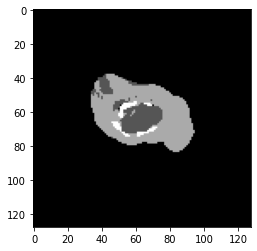

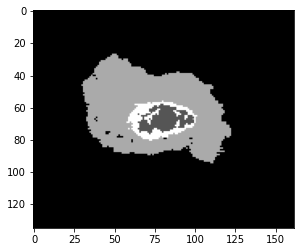

In [ ]:
plt.imshow(pred[:, :, 30], cmap='gray')
plt.show()
plt.imshow(lbl[:,:,30],cmap='gray')
plt.show()

In [ ]:
plt.imshow(lbl_c[:,:,30,1],cmap='gray')

NameError: ignored

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18045678471145434095
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13350618745232099892
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]
